Overview
========

This is a completely self-contained ipython notebook. 
I start with the problem that I'm trying to solve, with various explanations along the way.

I'm also attempting to use Markov-Chain Monte Carlo and various python packages to solve these problems. 
I've been convinced that some version of Bayesian analysis is the way to go about solving this problem, but I can't match the explanations that I've read with how to solve my problem. While I'm an expert in absorption spectroscopy, I am a complete amateur at this kind of analysis -- so if you see me doing something that you think is *weird*, don't assume that I have some really good really hidden reason for doing that way, it probably is weird.

Also, I'm at the point where I'm not sure if I'm taking the right approach. I half-way assume that someone will see what I'm doing and immediately say, "why don't you just use the parallel-tempering-markov-chain-monte-carlo implementation in emcee?" and I will respond, "because I didn't know that thing existed!"

In other words, please give feedback! Ask questions and offer suggestions!

The Problem
-------------

The work I do involves some tricky stuff, so let's start with a toy example that is hopefully easy to understand, and then move onto the tougher stuff.

Here is a toy example of the kind of thing I'm looking at: 

<img src="http://upload.wikimedia.org/wikipedia/commons/d/d7/Cumulative-absorption-spectrum-hubble-telescope.jpg">

Where it shows a bright background light from a background [quasar](http://en.wikipedia.org/wiki/Quasar) and the effect that each of the intervening clouds of gas have on the background light (absorption). Finally, the light we detect with telescopes is the background light minus all the absorption that it encountered along its journey.

It's worth taking a look at the Wikipedia article on [spectral lines](http://en.wikipedia.org/wiki/Spectral_line) if you're interested in getting an overview of the physics. It includes the helpful examples.

Continuous spectrum:

<img src="http://upload.wikimedia.org/wikipedia/commons/5/57/Spectral_lines_continous.png">

Emission spectrum: 

<img src="http://upload.wikimedia.org/wikipedia/commons/a/af/Spectral_lines_emission.png">

Absorption spectrum: 

<img src="http://upload.wikimedia.org/wikipedia/commons/b/b8/Spectral_lines_absorption.png">

Where the relationship between absorption and emission should be easily seen (they are the reverse of each other). 

Of course, the real thing we see is much more complicated; it looks more like this:

<img src="http://www.ucolick.org/graphics/echelle_lg.jpg">

But we're going to zoom WAY in on this kind of data. 
Anyway, let's dig into some code to start modeling what's happening out in the universe!

## Toy Example

In [36]:
import pymc as mc
import numpy as np
import datetime
from scipy import constants
c_light_kms = constants.c / 1000.

# grab it from http://nhmc.github.io/Barak/
#import barak
#from barak import absorb
#from barak import convolve
#from barak import voigt
#from barak import pyvpfit

%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
from matplotlib.backends.backend_pdf import PdfPages
pylab.rcParams['figure.figsize'] = 13, 7

In [37]:
def VoigtAbsorption(tau_array):
    return np.exp(-tau_array)

def GaussFunction(wavelength_array, amplitude, centroid, sigma, *args, **kwargs):
    return amplitude * np.exp(-0.5 * ((wavelength_array - centroid) / sigma)**2)


In [38]:
# Instrument detection region
wavelength_array = np.arange(5010, 5030, 0.02) # The units in wavelength will be in Angstroms


# Create some physical clouds
# each clouds is fully specified by 3 numbers: 
# An amplitude, a centroid, and a sigma-width

# cloud one
amplitude_one = 0.85
centroid_one = 5017.5
sigma_one = 1.2

# cloud two
amplitude_two = 0.35
centroid_two = 5018.1
sigma_two = 0.7

tau_array_one = GaussFunction(wavelength_array, amplitude_one, centroid_one, sigma_one)
tau_array_two = GaussFunction(wavelength_array, amplitude_two, centroid_two, sigma_two)

total_tau = tau_array_one + tau_array_two

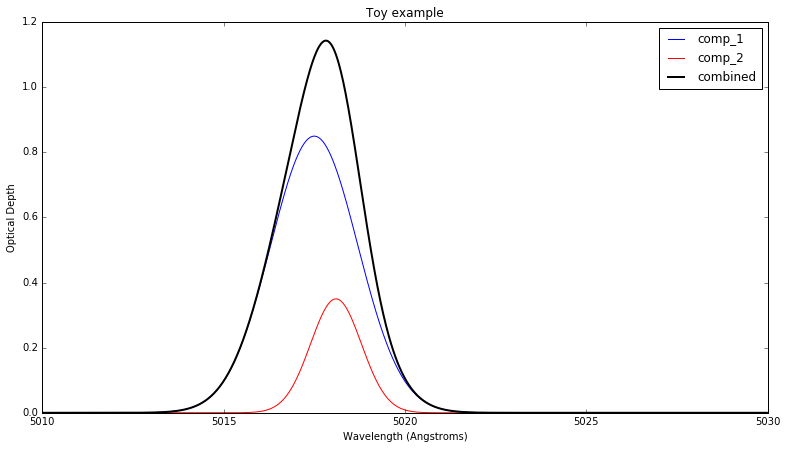

In [39]:
pylab.plot(wavelength_array, tau_array_one, color='blue', label='comp_1')
pylab.plot(wavelength_array, tau_array_two, color='red', label='comp_2')
pylab.plot(wavelength_array, total_tau, color='black', label='combined', linewidth=2.0)
pylab.ylabel("Optical Depth")
pylab.xlabel("Wavelength (Angstroms)")
pylab.legend()
pylab.title("Toy example")

I have suggestively labeled the y-axis: [Optical Depth](http://en.wikipedia.org/wiki/Optical_depth) for a reason.
You can think of the optical depth as the 'thickness' in units of [mean free path](http://en.wikipedia.org/wiki/Mean_free_path). 

A loose way of thinking about it as you look at the plot above is "non-normalized chance of background light being scattered vs. its wavelength". 
We don't detect optical depth directly, though, we have to infer it by the reduction in the background source's intensity. 

In [28]:
# Error, noise, etc.
onesigmaerror = 0.02 # error and noise normalized flux
noise = np.random.normal(0.0, onesigmaerror, len(wavelength_array))

flux_array = VoigtAbsorption(total_tau) + noise

(0, 1.1)

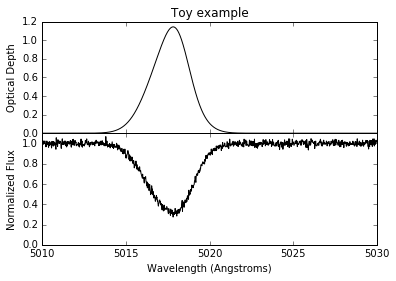

In [29]:
f, (ax1, ax2) = pylab.subplots(2, sharex=True, sharey=False)
ax1.plot(wavelength_array, total_tau, color='black', label='combined')
ax2.plot(wavelength_array, flux_array, color='black', label='flux')
f.subplots_adjust(hspace=0)

ax1.set_title("Toy example")
ax1.set_ylabel("Optical Depth")

ax2.set_ylabel("Normalized Flux")
ax2.set_xlabel("Wavelength (Angstroms)")
ax2.set_ylim(0, 1.1)

This plot shows the subsequent "dimming" of the background flux as a function of wavelength. If the flux went all the way to zero, it means that no light is getting through at that wavelength (and that is called saturation). 

Again, this "dip" in the flux (intensity) shows up as a dark band on the colorful examples above. 

The example is of a blended line -- meaning it has overlapping features. We have explicitly coded them in as the two Gaussians. So, how does one fit for this structure when all you see is a single dip in the flux spectrum? It's tricky, and will only get trickier from here on out...

Quick thanks to [Cameron Davidson-Pilon](http://camdp.com/) for answering my [stackoverflow question](http://stackoverflow.com/questions/15184293/fit-two-normal-distributions-histograms-with-mcmc-using-pymc) and is working on the very cool: [Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) book (ipython notebook!).

PyMC implementation 
----------------------

In [30]:
estimated_variables = {}
height_lower = 0
height_higher = 3
wavelength_lower = wavelength_array[0]
wavelength_upper = wavelength_array[-1]
sigma_lower = 0
sigma_upper = 5

In [31]:
fitComponents = 2

estimated_variables = {}
for component in range(1, fitComponents + 1):
    estimated_variables[component] = {}
    estimated_variables[component]['height'] = mc.Uniform("est_height_" + str(component), height_lower, height_higher)
    estimated_variables[component]['centroid'] = mc.Uniform("est_centroid_" + str(component), wavelength_lower, wavelength_upper)
    estimated_variables[component]['sigma'] = mc.Uniform("est_sigma_" + str(component), sigma_lower, sigma_upper)

#std deviation of the noise, converted to precision by tau = 1/sigma**2
std_deviation = 1./noise**2

estimate_profiles = []
for component in range(1, fitComponents + 1):
    @mc.deterministic( trace = False) 
    def func(x=wavelength_array, \
             centroid=estimated_variables[component]['centroid'], \
             sigma=estimated_variables[component]['sigma'], \
             height=estimated_variables[component]['height']):
        return GaussFunction( x, height, centroid, sigma )
    estimate_profiles.append(func)
    
@mc.deterministic( trace=False )
def mean(profile_sum=estimate_profiles):
    temp = profile_sum[0].copy()
    for component in range(1, fitComponents):
        temp += profile_sum[component]
    return VoigtAbsorption(temp)

In [32]:
observations = mc.Normal("obs", mean, std_deviation, value=flux_array, observed = True)
trymodel = mc.Model([estimated_variables[x][y] for x in estimated_variables for y in estimated_variables[x]] + [std_deviation])
map_ = mc.MAP( trymodel )
map_.fit()

trymcmc = mc.MCMC( trymodel )

In [33]:
starttime=datetime.datetime.now()
trymcmc.sample(iter=10000, burn=6000, thin=2.0)
fit_time = str(datetime.datetime.now() - starttime)
print "\nTook:", fit_time, " to finish."

 [-----------------100%-----------------] 10000 of 10000 complete in 10.0 sec
Took: 0:00:10.032536  to finish.


In [34]:
fit = {}
fit['total'] = np.zeros_like(wavelength_array)
for fitcomponent in range(1, fitComponents+1):
    fit[fitcomponent] = GaussFunction(wavelength_array, estimated_variables[fitcomponent]['height'].value, estimated_variables[fitcomponent]['centroid'].value, estimated_variables[fitcomponent]['sigma'].value)
    fit['total'] += fit[fitcomponent]


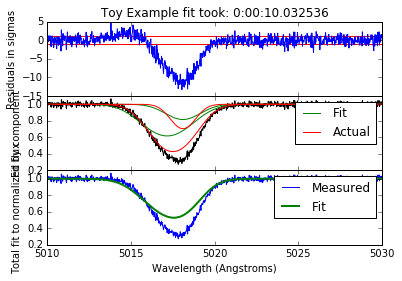

In [35]:
f, (ax1, ax2, ax3) = pylab.subplots(3, sharex=True, sharey=False)
ax1.plot(wavelength_array, (flux_array - VoigtAbsorption(fit['total'])) / onesigmaerror)
ax1.hlines(1, wavelength_array[0], wavelength_array[-1], color='red', linestyles='-')
ax1.hlines(-1, wavelength_array[0], wavelength_array[-1], color='red', linestyles='-')
ax2.plot(wavelength_array, flux_array, color='black', linewidth=1.0)
for fitcomponent in range(1, fitComponents+1):
    if fitcomponent == 1:
        ax2.plot(wavelength_array, VoigtAbsorption(fit[fitcomponent]), color="green", label="Fit")
    else: 
        ax2.plot(wavelength_array, VoigtAbsorption(fit[fitcomponent]), color="green",)
ax2.plot(wavelength_array, VoigtAbsorption(tau_array_one), color="red", label="Actual")
ax2.plot(wavelength_array, VoigtAbsorption(tau_array_two), color="red",)
#ax2.plot(wavelength, profiles[2]['flux'], color="red")
ax2.legend()
ax3.plot(wavelength_array, flux_array, label="Measured")
ax3.plot(wavelength_array, VoigtAbsorption(fit['total']), color='green', label="Fit", linewidth=2.0)
ax3.legend()
f.subplots_adjust(hspace=0)
ax1.set_title("Toy Example fit took: " + fit_time)
ax1.set_ylabel("Residuals in sigmas")
ax2.set_ylabel("Fit by component")
ax3.set_ylabel("Total fit to normalized flux")
ax3.set_xlabel("Wavelength (Angstroms)")

Different numbers of components (clouds)
------------------------------

With the above example we see that it does a good job of finding *an* acceptable fit to the data. But we explicitly hard-coded 2 fitting components.
Trying again by explicitly fitting three we get: 

In [17]:
fitComponents = 3

estimated_variables = {}
for component in range(1, fitComponents + 1):
    estimated_variables[component] = {}
    estimated_variables[component]['height'] = mc.Uniform("est_height_" + str(component), height_lower, height_higher)
    estimated_variables[component]['centroid'] = mc.Uniform("est_centroid_" + str(component), wavelength_lower, wavelength_upper)
    estimated_variables[component]['sigma'] = mc.Uniform("est_sigma_" + str(component), sigma_lower, sigma_upper)

#std deviation of the noise, converted to precision by tau = 1/sigma**2
std_deviation = 1./noise**2

estimate_profiles = []
for component in range(1, fitComponents + 1):
    @mc.deterministic( trace = False) 
    def func(x=wavelength_array, \
             centroid=estimated_variables[component]['centroid'], \
             sigma=estimated_variables[component]['sigma'], \
             height=estimated_variables[component]['height']):
        return GaussFunction( x, height, centroid, sigma )
    estimate_profiles.append(func)
    
@mc.deterministic( trace=False )
def mean(profile_sum=estimate_profiles):
    temp = profile_sum[0].copy()
    for component in range(1, fitComponents):
        temp += profile_sum[component]
    return VoigtAbsorption(temp)

In [18]:
observations = mc.Normal("obs", mean, std_deviation, value=flux_array, observed = True)
trymodel = mc.Model([estimated_variables[x][y] for x in estimated_variables for y in estimated_variables[x]] + [std_deviation])
map_ = mc.MAP( trymodel )
map_.fit()

trymcmc = mc.MCMC( trymodel )

In [19]:
starttime=datetime.datetime.now()
trymcmc.sample(iter=10000, burn=6000, thin=2.0)
fit_time = str(datetime.datetime.now() - starttime)
print "\nTook:", fit_time, " to finish."

 [-----------------100%-----------------] 10000 of 10000 complete in 11.4 sec
Took: 0:00:11.429674  to finish.


In [20]:
fit = {}
fit['total'] = np.zeros_like(wavelength_array)
for fitcomponent in range(1, fitComponents+1):
    fit[fitcomponent] = GaussFunction(wavelength_array, estimated_variables[fitcomponent]['height'].value, estimated_variables[fitcomponent]['centroid'].value, estimated_variables[fitcomponent]['sigma'].value)
    fit['total'] += fit[fitcomponent]


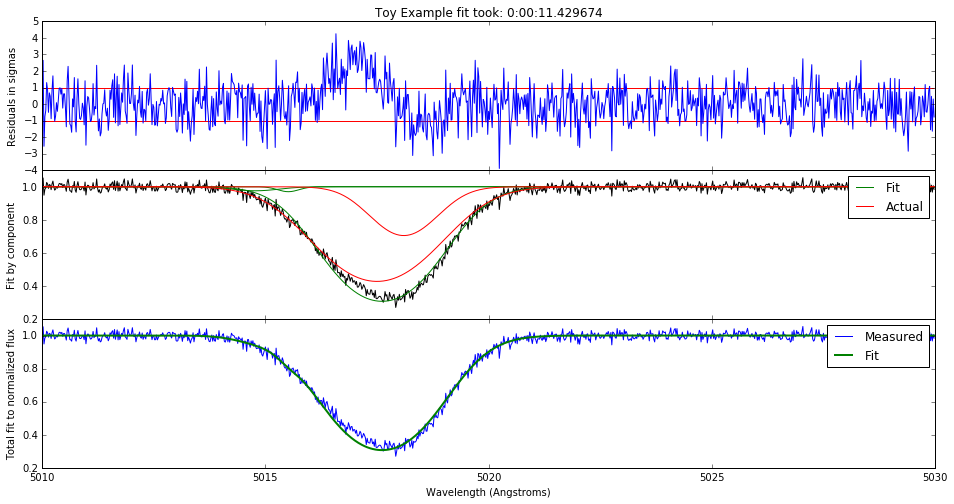

In [21]:
f, (ax1, ax2, ax3) = pylab.subplots(3, sharex=True, sharey=False)
ax1.plot(wavelength_array, (flux_array - VoigtAbsorption(fit['total'])) / onesigmaerror)
ax1.hlines(1, wavelength_array[0], wavelength_array[-1], color='red', linestyles='-')
ax1.hlines(-1, wavelength_array[0], wavelength_array[-1], color='red', linestyles='-')
ax2.plot(wavelength_array, flux_array, color='black', linewidth=1.0)
for fitcomponent in range(1, fitComponents+1):
    if fitcomponent == 1:
        ax2.plot(wavelength_array, VoigtAbsorption(fit[fitcomponent]), color="green", label="Fit")
    else: 
        ax2.plot(wavelength_array, VoigtAbsorption(fit[fitcomponent]), color="green",)
ax2.plot(wavelength_array, VoigtAbsorption(tau_array_one), color="red", label="Actual")
ax2.plot(wavelength_array, VoigtAbsorption(tau_array_two), color="red",)
#ax2.plot(wavelength, profiles[2]['flux'], color="red")
ax2.legend()
ax3.plot(wavelength_array, flux_array, label="Measured")
ax3.plot(wavelength_array, VoigtAbsorption(fit['total']), color='green', label="Fit", linewidth=2.0)
ax3.legend()
f.subplots_adjust(hspace=0)
ax1.set_title("Toy Example fit took: " + fit_time)
ax1.set_ylabel("Residuals in sigmas")
ax2.set_ylabel("Fit by component")
ax3.set_ylabel("Total fit to normalized flux")
ax3.set_xlabel("Wavelength (Angstroms)")

Which is also a nice fit to the data (or run it for 50000/40000 iterations/burn). Which to choose gets into model selection, which I'll hold off on talking about for now. So that should give the basic idea of what's happening.

We detect a dip in flux as a function of wavelength using a spectrograph. This dip corresponds to a cloud (or two, or three, or...) in space.
We can model this and fit for the parameters of the model. 

## Closer to real stuff

This is an iron (Fe) spectrum, which is the physical process that's actually being modeled: 

What you see here is an emission spectrum (which is exactly the opposite of absorption) from iron: 

<img src="http://upload.wikimedia.org/wikipedia/commons/5/52/Emission_spectrum-Fe.svg">

Or a slightly more realistic version: 

<img src="http://upload.wikimedia.org/wikipedia/commons/6/6a/Iron_Spectrum.jpg"> 

What you should notice is that there are many many many lines for iron. What you are seeing, in effect, is all of the energy levels available to the outer most electron in an iron atom. There are many different levels that that atom can be kicked into -- with differing probabilities for each jump.

The strength of the line depends on the wavelength of light, and the quantum mechanical probability of the transition happening. It turns out that some jumps are billions of times more likely to happen than others. In absorption this translates into a much "deeper" line.

A lot of the following code relies on [Neil Crighton](http://www.mpia-hd.mpg.de/homes/nhmc/)'s excellent [Barak](http://nhmc.github.io/Barak/) library. So if you want to run this yourself, you'll have to grab that code (pip install barak).

In [22]:
pixel_size = 1.3 # km/s per pixel
subsample_factor = int(9)

# These functions calculate the theoretical tau/flux on a grid smaller than pixel-size 
# so that the integration across the pixel can be more accurately calculated.
def subsample(wave, subsample_factor=subsample_factor, pixel_size=pixel_size):
    # Assumes wave was created by make_constant_dv_wa_scale
    # pixel_size is in km/s of the original wave array
    begin_size = wave[1] - wave[0]
    end_size = wave[-1] - wave[-2]
    subwave = barak.sed.make_constant_dv_wa_scale(wave[0] - begin_size/2.0, wave[-1] + end_size, pixel_size/subsample_factor)
    return subwave[:len(wave) * subsample_factor]

def co_add_from_subsample(subsampled_flux, subsample_factor=subsample_factor):
    starting_length = len(subsampled_flux)
    intermediate_step = subsampled_flux.reshape(starting_length/subsample_factor, subsample_factor)/float(subsample_factor)
    return np.sum(intermediate_step, axis=1)

The following is a small selection of iron atomic transitions that are centered on various rest wavelengths.

In [23]:
with open('cut-atom.dat', 'w') as filehandle: 
    print >> filehandle, """FeII  2600.1721140 0.23900000 2.700E+08  55.8450   1370.0 
FeII  2586.6493120 0.06910000 2.720E+08  55.8450   1515.0 
FeII  2382.7639950 0.32000000 3.130E+08  55.8450   1505.0 
FeII  2374.4600640 0.03130000 3.090E+08  55.8450   1625.0 
FeII  2367.5892400 0.00002160 3.070E+08  55.8450   1803.0 
FeII  2344.2127470 0.11400000 2.680E+08  55.8450   1375.0 
FeII  2260.7791080 0.00244000 2.580E+08  55.8450   1435.0 
FeII  2249.8754720 0.00182000 3.310E+08  55.8450   1604.0 
FeII  1611.2003690 0.00138000 2.860E+08  55.8450   1330.0 
FeII  1608.4508520 0.05770000 2.740E+08  55.8450  -1165.0 
"""
atomDict = absorb.readatom('cut-atom.dat') # Load in the just-created file for the barak library

NameError: name 'absorb' is not defined

In [114]:
# Create physical clouds (this generates the number of clouds)
true_components = 2

# As before, these rely on 3 parameters but they have different names
# z is cosmological redshift
# b is width of the line (like sigma above)
# N is log of column density (number of iron atoms in the cloud) sorta like amplitude above
z_lower = 1.7108
z_upper = 1.711
b_lower = 0.7
b_upper = 6.5
N_lower = 11.5
N_upper = 14.2

# Observed spectrum
onesigmaerror = 0.02

pixel_size = 1.3 # km/s
subsample_factor = int(9) # 
subpixel_size = pixel_size / subsample_factor # km/s
instrument_profile = 2.5 # km/s

lineList = []

wavelength_buffer = 1.5 # Wavelength region extension
lower_wavelength_factor = (1 + z_lower)
upper_wavelength_factor = (1 + z_upper)

trans1 = 1608.4507986
trans2 = 1611.2004037
trans3 = 2382.7640777 
trans4 = 2600.1721140 
trans5 = 2344.2127470 

wavelength1 = barak.sed.make_constant_dv_wa_scale(trans1 * lower_wavelength_factor - wavelength_buffer, \
                            trans2 * upper_wavelength_factor + wavelength_buffer, \
                            pixel_size)

# 2382
wavelength2 = barak.sed.make_constant_dv_wa_scale(trans5 * lower_wavelength_factor - wavelength_buffer, \
                            trans5 * upper_wavelength_factor + wavelength_buffer, \
                            pixel_size)

wavelength3 = barak.sed.make_constant_dv_wa_scale(trans3 * lower_wavelength_factor - wavelength_buffer, \
                            trans3 * upper_wavelength_factor + wavelength_buffer, \
                            pixel_size)

wavelengthList = np.array([wavelength1, wavelength2, wavelength3])
#wavelengthList = np.array([wavelength3])

wavelength = np.array(np.hstack(wavelengthList))

noiseList = np.array([np.random.normal(0.0, onesigmaerror, len(wave)) for wave in wavelengthList])
noise = np.hstack(noiseList)

In [115]:
profiles = {}
for component in range(1, true_components + 1):
    tempz = np.random.uniform(z_lower, z_upper)
    tempb = np.random.uniform(b_lower, b_upper)
    tempN = np.random.uniform(N_lower, N_upper)
    lineList.append(('FeII', tempz, tempb, tempN,))
    profiles[component] = {}
    profiles[component]['true_feature'] = ('FeII', tempz, tempb, tempN)
    
observed = {}
for region_index, region_wavelength in enumerate(wavelengthList):
    observed[region_index] = {}
    observed[region_index]['total'] = np.zeros_like(subsample(region_wavelength))
    for component in range(1, true_components + 1):
        observed[region_index][component] = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(absorb.find_tau(subsample(region_wavelength), \
                                            [profiles[component]['true_feature']], \
                                            atomDict, )[0])), \
                                                instrument_profile)
        observed[region_index]['total'] += absorb.find_tau(subsample(region_wavelength), \
                                            [profiles[component]['true_feature']], \
                                            atomDict, )[0]
    observed[region_index]['observed'] = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(observed[region_index]['total'])), \
                                                instrument_profile)\
                                            + noiseList[region_index]
    observed[region_index]['true_model'] = VoigtAbsorption(co_add_from_subsample(observed[region_index]['total']))
    observed[region_index]['IP_true_model'] = convolve.convolve_psf(observed[region_index]['true_model'], instrument_profile)

total_observed = np.hstack(observed[region_index]['observed'] for region_index in range(len(wavelengthList)))

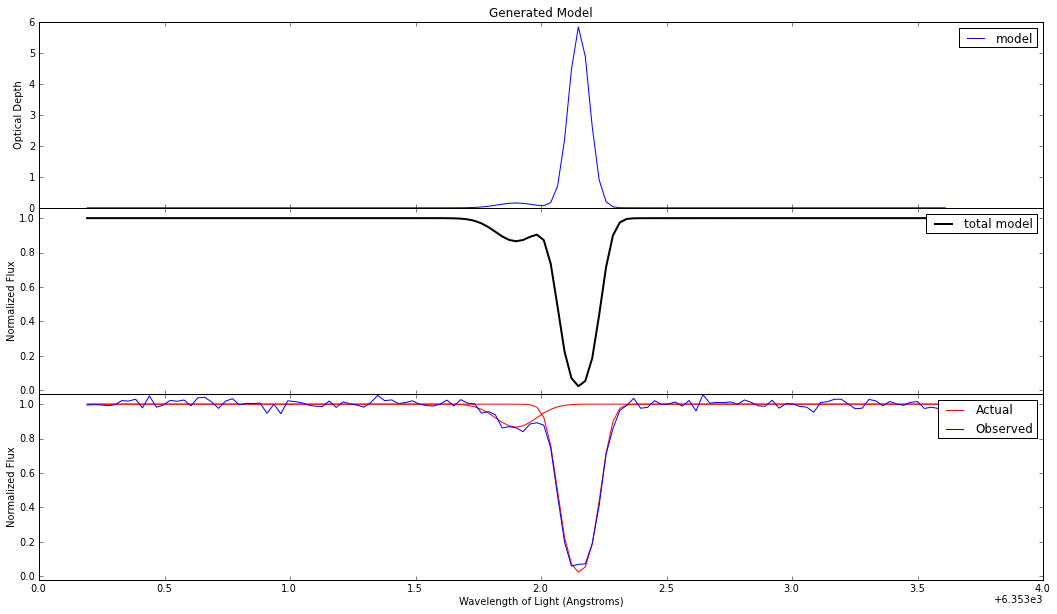

In [116]:
region_index=1
f, (ax1, ax2, ax3) = pylab.subplots(3, sharex=True, sharey=False)
ax1.plot(wavelengthList[region_index], co_add_from_subsample(observed[region_index]['total']), label='model')
ax2.plot(wavelengthList[region_index], observed[region_index]['IP_true_model'], label='total model', color='black', linewidth=2.0)
for component in range(1, true_components + 1):
    if component == 1:
        ax3.plot(wavelengthList[region_index], observed[region_index][component], color="red", label="Actual")
    else:
        ax3.plot(wavelengthList[region_index], observed[region_index][component], color="red")
ax3.plot(wavelengthList[region_index], observed[region_index]['observed'], label='Observed')
ax1.legend()
ax2.legend()
ax1.set_ylabel("Normalized Flux")
ax1.set_title("Generated Model")
ax3.legend()
lowery = -0.02
uppery = 1.06
#ax1.set_ylim(lowery, uppery)
ax2.set_ylim(lowery, uppery)
ax3.set_ylim(lowery, uppery)
ax1.set_ylabel("Optical Depth")
ax2.set_ylabel("Normalized Flux")
ax3.set_ylabel("Normalized Flux")
ax3.set_xlabel("Wavelength of Light (Angstroms)")
f.subplots_adjust(hspace=0)
#pylab.savefig("single-example.pdf")

In [112]:
extra_fit_components = 0
fit_components = true_components + extra_fit_components
estimated_variables = {}
fit_N_lower = N_lower - 0.5
fit_N_upper = N_upper + 0.5
fit_b_lower = b_lower - 0.1
fit_b_upper = b_upper + 3.5
fit_z_lower = z_lower - 0.00005
fit_z_upper = z_upper + 0.00005

# Instrument profile
fit_instrument_profile_lower = instrument_profile - 0.5
fit_instrument_profile_upper = instrument_profile + 0.5

estimated_variables = {}
for component in range(1, fit_components + 1):
    estimated_variables[component] = {}
    estimated_variables[component]['fit_z'] = mc.Uniform("est_z_" + str(component), fit_z_lower, fit_z_upper)
    estimated_variables[component]['fit_N'] = mc.Uniform("est_N_" + str(component), fit_N_lower, fit_N_upper)
    estimated_variables[component]['fit_b'] = mc.Uniform("est_b_" + str(component), fit_b_lower, fit_b_upper)
    
estimated_instrument_profile = mc.Uniform("est_IP", fit_instrument_profile_lower, fit_instrument_profile_upper)

std_deviation = 1./noise**2

In [113]:
@mc.deterministic( trace=False )
def mean(region_list=wavelengthList, \
         fit_component_guesses=estimated_variables, \
         fit_instrument_profile=estimated_instrument_profile):
    """Creates the absorption for the components"""
    fit_flux = {}
    for region_index, region_wavelength in enumerate(region_list):
        fit_flux[region_index] = {}
        fit_flux[region_index]['total'] = np.zeros_like(subsample(region_wavelength))
    for fitcomponent in  range(1, fit_components + 1):
        z = fit_component_guesses[fitcomponent]['fit_z']
        b = fit_component_guesses[fitcomponent]['fit_b']
        N = fit_component_guesses[fitcomponent]['fit_N']
        for region_index, region_wavelength in enumerate(region_list):
            fit_flux[region_index]['total'] += absorb.find_tau(subsample(region_wavelength), \
                                                    [('FeII', z, b, N, )], \
                                                    atomDict, )[0]
    for region_index, region_wavelength in enumerate(region_list):
        fit_flux[region_index]['flux'] = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(fit_flux[region_index]['total'])), \
                                                        fit_instrument_profile)
    return np.hstack(fit_flux[region_index]['flux'] for region_index in range(len(wavelengthList)))

In [89]:
observations = mc.Normal("obs", mean, std_deviation, value=total_observed, observed=True)
trymodel = mc.Model([estimated_variables[x][y] for x in estimated_variables for y in estimated_variables[x]] + [std_deviation] + \
                    [estimated_instrument_profile])

In [90]:
map_ = mc.MAP( trymodel )

In [91]:
first_fit = datetime.datetime.now()
map_.fit()
trymcmc = mc.MCMC( trymodel )
print "Initial fit time: ", str(datetime.datetime.now() - first_fit)

Initial fit time:  0:00:11.179322


In [92]:
starttime = datetime.datetime.now()
print "Starting time: ", starttime
iterations = 12000
burn=6000
thin=2.0
trymcmc.sample(iter=iterations, burn=burn)
finishtime = datetime.datetime.now()
sampletime = str(finishtime - starttime)
print "\nTook:", sampletime, " to finish", str(iterations), "iterations."

[****************100%******************]  12000 of 12000 complete 
Took: 0:10:15.518692  to finish 12000 iterations.


In [93]:
fit_flux = {}
for region_index, region_wavelength in enumerate(wavelengthList):
    fit_flux[region_index] = {}
    fit_flux[region_index]['total'] = np.zeros_like(subsample(region_wavelength))
    for component in range(1, fit_components + 1):
        fit_flux[region_index]['total'] += absorb.find_tau(subsample(region_wavelength), [('FeII', \
                                        estimated_variables[component]['fit_z'].value, \
                                        estimated_variables[component]['fit_b'].value, \
                                        estimated_variables[component]['fit_N'].value)], atomDict, )[0]
        fit_flux[region_index][component] = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(absorb.find_tau(subsample(region_wavelength), \
                                        [('FeII', \
                                        estimated_variables[component]['fit_z'].value, \
                                        estimated_variables[component]['fit_b'].value, \
                                        estimated_variables[component]['fit_N'].value)], atomDict, )[0])), \
                                        estimated_instrument_profile.value)

    fit_flux[region_index]['flux'] = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(fit_flux[region_index]['total'])), \
                                                        estimated_instrument_profile.value)


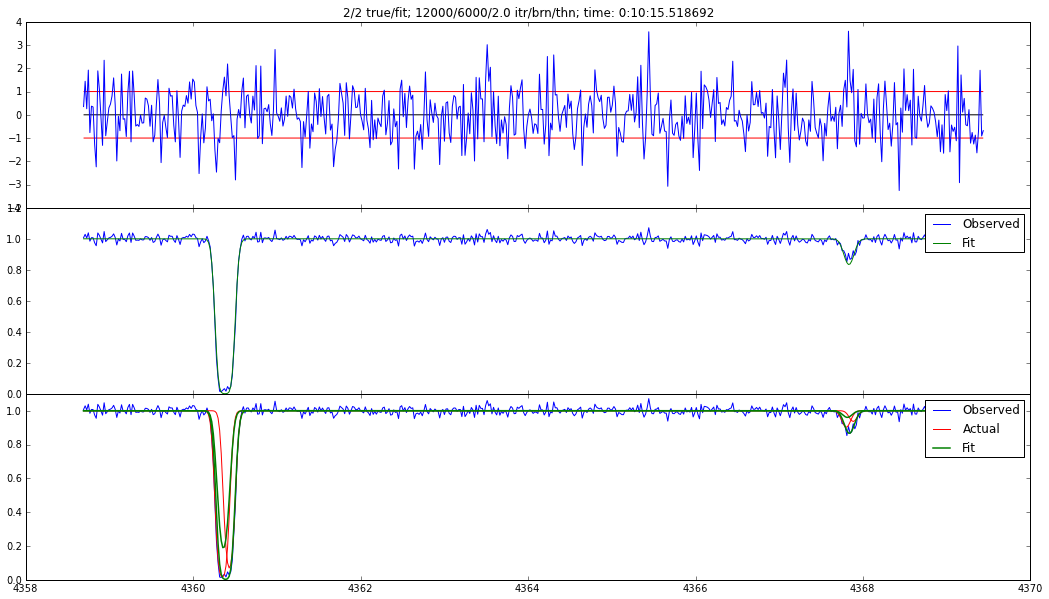

In [101]:
pylab.rcParams['figure.figsize'] = 18, 10  # that's default image size for this interactive session

region_index = 0
f, (ax1, ax2, ax3) = pylab.subplots(3, sharex=True, sharey=False)
ax1.plot(wavelengthList[region_index], (observed[region_index]['observed'] - fit_flux[region_index]['flux']) / onesigmaerror)
ax1.hlines(1.0, wavelengthList[region_index][0], wavelengthList[region_index][-1], color='red', linestyles='-')
ax1.hlines(0, wavelengthList[region_index][0], wavelengthList[region_index][-1], color='black') 
ax1.hlines(-1.0, wavelengthList[region_index][0], wavelengthList[region_index][-1], color='red', linestyles='-')
ax2.plot(wavelengthList[region_index], observed[region_index]['observed'], label="Observed")
ax2.plot(wavelengthList[region_index], fit_flux[region_index]['flux'], color='green', label="Fit")
ax2.legend()
ax3.plot(wavelengthList[region_index], observed[region_index]['observed'], label="Observed")
for component in range(1, true_components + 1):
    if component == 1:
        ax3.plot(wavelengthList[region_index], observed[region_index][component], color="red", label="Actual")
    else:
        ax3.plot(wavelengthList[region_index], observed[region_index][component], color="red")
for fitcomponent in range(1, fit_components + 1):
    if fitcomponent == 1:
        ax3.plot(wavelengthList[region_index], fit_flux[region_index][fitcomponent], color="green", label="Fit", linewidth=1.5)
    else:
        ax3.plot(wavelengthList[region_index], fit_flux[region_index][fitcomponent], color="green", linewidth=1.5)
ax3.set_ylim(0, 1.1)
ax3.legend()
f.subplots_adjust(hspace=0)
ax1.set_title(str(true_components) + "/" +  str(fit_components) + " true/fit; " + \
                str(iterations)+ "/" + str(burn) + "/" + str(thin) + " itr/brn/thn; time: " + sampletime)


In [95]:
# Creates multi-page pdf of plots
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S")

pdf = PdfPages(timestamp + ".flux.pdf")
for region_index in range(len(wavelengthList)):
    f, (ax1, ax2, ax3) = pylab.subplots(3, sharex=True, sharey=False)
    ax1.plot(wavelengthList[region_index], (observed[region_index]['observed'] - fit_flux[region_index]['flux']) / onesigmaerror)
    ax1.hlines(1.0, wavelengthList[region_index][0], wavelengthList[region_index][-1], color='red', linestyles='-')
    ax1.hlines(0, wavelengthList[region_index][0], wavelengthList[region_index][-1], color='black') 
    ax1.hlines(-1.0, wavelengthList[region_index][0], wavelengthList[region_index][-1], color='red', linestyles='-')
    ax2.plot(wavelengthList[region_index], observed[region_index]['observed'], label="Observed")
    ax2.plot(wavelengthList[region_index], fit_flux[region_index]['flux'], color='green', label="Fit")
    #ax2.set_ylim(0, 1.1)
    ax2.legend()
    ax3.plot(wavelengthList[region_index], observed[region_index]['observed'], label="Observed")
    for component in range(1, true_components + 1):
        if component == 1:
            ax3.plot(wavelengthList[region_index], observed[region_index][component], color="red", label="Actual")
        else:
            ax3.plot(wavelengthList[region_index], observed[region_index][component], color="red")
    for fitcomponent in range(1, fit_components + 1):
        if fitcomponent == 1:
            ax3.plot(wavelengthList[region_index], fit_flux[region_index][fitcomponent], color="green", label="Fit", linewidth=1.5)
        else:
            ax3.plot(wavelengthList[region_index], fit_flux[region_index][fitcomponent], color="green", linewidth=1.5)
    ax3.set_ylim(0, 1.1)
    ax3.legend()
    f.subplots_adjust(hspace=0)
    ax1.set_title(str(true_components) + "/" +  str(fit_components) + " true/fit; " + \
                    str(iterations)+ "/" + str(burn) + "/" + str(thin) + " itr/brn/thn; " + \
                    str(round(instrument_profile, 3)) + "/" + str(round(estimated_instrument_profile.value, 3)) + \
                    " realIP/fitIP; time: " + sampletime)
    pdf.savefig()
    pylab.close()

pdf.close()


In [96]:
# Create data, fort.13 files
#timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S")

for i, region in enumerate(wavelengthList):
    np.savetxt(timestamp + "." + str(i) + ".ascii", \
        (np.transpose([wavelengthList[i], observed[i]['observed'], np.ones_like(region) * onesigmaerror])))

with open(timestamp + ".true.13", 'w') as fh:
    #header
    print >>fh, "   *"
    for i, region in enumerate(wavelengthList):
        print >>fh, timestamp + "." + str(i) + ".ascii   1   ", region[0] + wavelength_buffer/2.0, region[-1] - wavelength_buffer/2.0, \
            "vfwhm=" + str(round(estimated_instrument_profile.value, 2))
    print >>fh, "  *"
    #body
    for x in range(1, true_components + 1):
        temp = profiles[x]['true_feature']
        if x == 1:
            print >>fh, temp[0], str(temp[3]), str(temp[1]) + "aa", temp[2], "  0.00E+00QA      0.00   1.00E+00  0 !    "
        else:
            print >>fh, temp[0], temp[3], temp[1], temp[2], "  0.00E+00QA      0.00   1.00E+00  0 !    "
        
with open(timestamp + ".fit.13", 'w') as fh:
    #header
    print >>fh, "   *"
    for i, region in enumerate(wavelengthList):
        print >>fh, timestamp + "." + str(i) + ".ascii   1   ", region[0] + wavelength_buffer/2.0, region[-1] - wavelength_buffer/2.0, \
            "vfwhm=" + str(round(estimated_instrument_profile.value, 2))
    print >>fh, "  *"
    for x in range(1, fit_components + 1):
        if x == 1:
            print >>fh, "FeII", estimated_variables[x]['fit_N'].value, \
                str(estimated_variables[x]['fit_z'].value) + "aa", \
                estimated_variables[x]['fit_b'].value, "  0.00E+00QA      0.00   1.00E+00  0 !    "
        else:
            print >>fh, "FeII", estimated_variables[x]['fit_N'].value, \
                estimated_variables[x]['fit_z'].value, \
                estimated_variables[x]['fit_b'].value, "  0.00E+00QA      0.00   1.00E+00  0 !    "


Future Thoughts
-------------

I'm at the stage where "everything works" -- basically. Although I have a number of thoughts and questions.  

When I scale up to about 30 blended clouds with the Gaussian example, it easily takes an hour to find an decent fit. The same is NOT true with the Voigt profile fitting I do later on. It will take ~24 hours to run 10000 iterations (which is a TON) and it probably needs an order of magnitude more iterations to even start to be rigorous. 

Any thoughts on how to speed up what I'm already doing -- please let me know! However, as this is my first implementation I suspect there are other approaches that I'm ignorant of that might suit the problem much more. 


Other approaches
-------

I'm very new to this game -- I've been looking around for other things that might be a fundamentally better approach. Among them: 

 * [emcee](http://dan.iel.fm/emcee/) -- [Parallel-Tempering Ensemble MCMC](http://dan.iel.fm/emcee/user/pt/)
 * [astroml](http://astroml.github.io/index.html) -- [Extreme Deconvolution](http://astroml.github.io/paper_figures/CIDU2012/fig_XD_example.html)
 * [sci-kit learn](http://scikit-learn.org/dev/) -- [PCA decomposition](http://scikit-learn.org/dev/modules/decomposition.html)

Anyone with any hints, suggestions or help please contact me!

jbwhit@gmail.com
